#  Modeling
Borrowing heavily from https://www.tensorflow.org/tutorials/images/classification to start

## Imports

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

## Functions

In [14]:
def graphmodel(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Set-up before modeling

In [23]:
# Set variables for ease of manipulation

data_path = os.getcwd() + '\\PokeImages-by-type'
batch_size = 32
img_height = 128
img_width = 128

### Train / Test Split

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33877 files belonging to 17 classes.
Using 27102 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33877 files belonging to 17 classes.
Using 6775 files for validation.


In [26]:
class_names = train_ds.class_names

In [6]:
class_names

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

### Tune for performance
Following tutorial, need to investigate further

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## First Simple Model
With batch size = 32

In [37]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)       

In [40]:
%%time

epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
847/847 [==============================] - 8s 9ms/step - loss: 2.2618 - accuracy: 0.2994 - val_loss: 1.8667 - val_accuracy: 0.4137
Epoch 2/20
847/847 [==============================] - 8s 9ms/step - loss: 1.3859 - accuracy: 0.5792 - val_loss: 1.1216 - val_accuracy: 0.6739
Epoch 3/20
847/847 [==============================] - 8s 9ms/step - loss: 0.6519 - accuracy: 0.8020 - val_loss: 0.7749 - val_accuracy: 0.7888
Epoch 4/20
847/847 [==============================] - 8s 9ms/step - loss: 0.2975 - accuracy: 0.9092 - val_loss: 0.7911 - val_accuracy: 0.8269
Epoch 5/20
847/847 [==============================] - 7s 9ms/step - loss: 0.1732 - accuracy: 0.9426 - val_loss: 0.7830 - val_accuracy: 0.8425
Epoch 6/20
847/847 [==============================] - 7s 9ms/step - loss: 0.1309 - accuracy: 0.9583 - val_loss: 0.7966 - val_accuracy: 0.8520
Epoch 7/20
847/847 [==============================] - 7s 9ms/step - loss: 0.1129 - accuracy: 0.9649 - val_loss: 0.8960 - val_accuracy: 0.8601
Epoch 

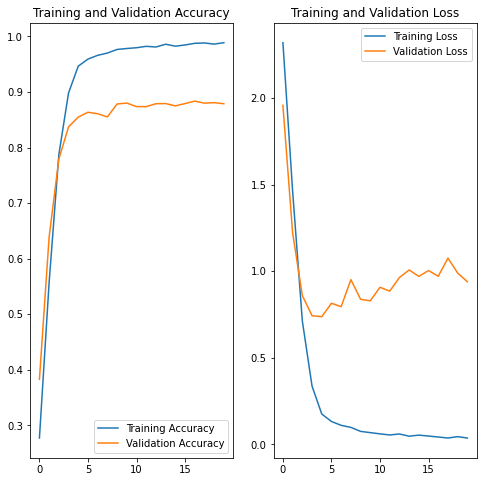

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

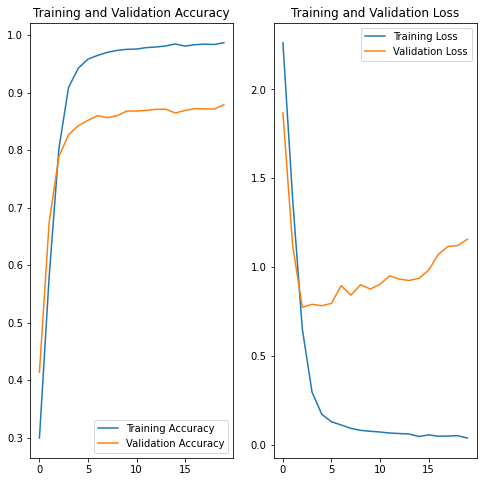

In [41]:
graphmodel(history)

#### First Model Evaluation
Accuracy of 87.9% for a model with 17 classes is a strong start.  There is clear evidence of overfitting and the loss in the validation data looks to be fairly high.

## Model 2: Adding Image Augmentation
Batch size = 32

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [33]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

In [34]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
%%time

epochs=50

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 38s 36ms/step - loss: 2.4789 - accuracy: 0.2312 - val_loss: 2.3685 - val_accuracy: 0.2714
Epoch 2/50
847/847 [==============================] - 31s 37ms/step - loss: 2.2411 - accuracy: 0.2978 - val_loss: 2.1301 - val_accuracy: 0.3250
Epoch 3/50
847/847 [==============================] - 30s 36ms/step - loss: 2.0881 - accuracy: 0.3375 - val_loss: 2.0096 - val_accuracy: 0.3621
Epoch 4/50
847/847 [==============================] - 31s 36ms/step - loss: 1.9326 - accuracy: 0.3819 - val_loss: 1.8360 - val_accuracy: 0.4146
Epoch 5/50
847/847 [==============================] - 30s 35ms/step - loss: 1.8014 - accuracy: 0.4248 - val_loss: 1.7507 - val_accuracy: 0.4463
Epoch 6/50
847/847 [==============================] - 29s 34ms/step - loss: 1.6693 - accuracy: 0.4685 - val_loss: 1.6252 - val_accuracy: 0.4803
Epoch 7/50
847/847 [==============================] - 29s 35ms/step - loss: 1.5702 - accuracy: 0.5006 - val_loss: 1.5791 - val_accuracy:

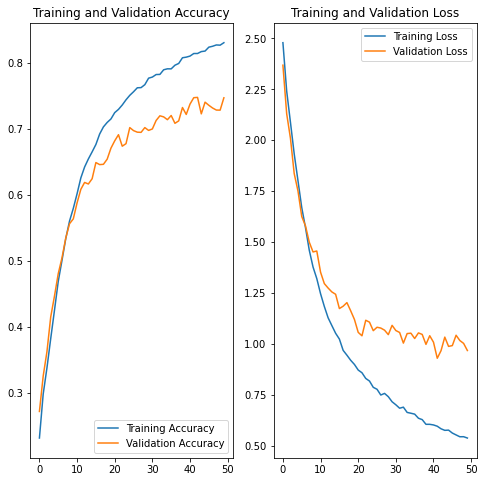

In [36]:
graphmodel(history2)

## Model 3: Batch Normalization, No Augmentation

In [57]:
model3 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
%%time

epochs=20

history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
847/847 [==============================] - 11s 12ms/step - loss: 2.5274 - accuracy: 0.2428 - val_loss: 2.2395 - val_accuracy: 0.3038
Epoch 2/20
847/847 [==============================] - 10s 11ms/step - loss: 1.8525 - accuracy: 0.4241 - val_loss: 1.7957 - val_accuracy: 0.4573
Epoch 3/20
847/847 [==============================] - 10s 11ms/step - loss: 1.1713 - accuracy: 0.6360 - val_loss: 1.1972 - val_accuracy: 0.6511
Epoch 4/20
847/847 [==============================] - 10s 12ms/step - loss: 0.6838 - accuracy: 0.7892 - val_loss: 1.0535 - val_accuracy: 0.7175
Epoch 5/20
847/847 [==============================] - 10s 12ms/step - loss: 0.4129 - accuracy: 0.8719 - val_loss: 0.8895 - val_accuracy: 0.7776
Epoch 6/20
847/847 [==============================] - 10s 11ms/step - loss: 0.2781 - accuracy: 0.9120 - val_loss: 0.8426 - val_accuracy: 0.7979
Epoch 7/20
847/847 [==============================] - 10s 12ms/step - loss: 0.2092 - accuracy: 0.9337 - val_loss: 0.8296 - val_accuracy:

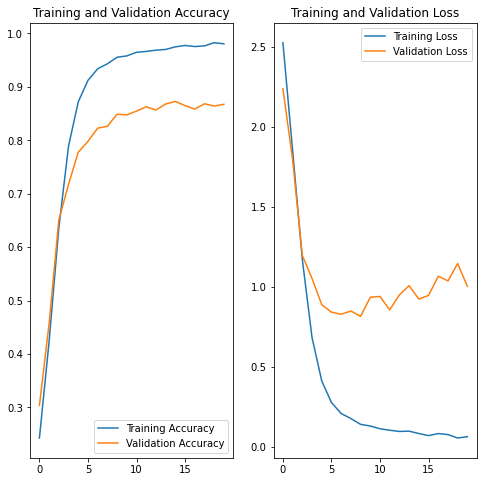

In [59]:
graphmodel(history3)

#### Model 3 Eval
Batch Normalization resulted in a roughly comparable, but slightly worse result than the FSM and a moderate performance penalty (~+3 seconds per epoch)

## Model 4: Mo' Dropout, Mo' Better?
Added several dropout layers and increased the number of epochs to allow more time to train 

In [64]:
model4 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
%%time

epochs=50

history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 9s 10ms/step - loss: 2.5060 - accuracy: 0.2225 - val_loss: 2.2843 - val_accuracy: 0.2940
Epoch 2/50
847/847 [==============================] - 8s 9ms/step - loss: 2.1171 - accuracy: 0.3395 - val_loss: 1.8069 - val_accuracy: 0.4483
Epoch 3/50
847/847 [==============================] - 8s 9ms/step - loss: 1.6641 - accuracy: 0.4795 - val_loss: 1.4453 - val_accuracy: 0.5734
Epoch 4/50
847/847 [==============================] - 8s 9ms/step - loss: 1.2943 - accuracy: 0.5858 - val_loss: 1.1400 - val_accuracy: 0.6717
Epoch 5/50
847/847 [==============================] - 8s 9ms/step - loss: 1.0277 - accuracy: 0.6654 - val_loss: 0.9511 - val_accuracy: 0.7398
Epoch 6/50
847/847 [==============================] - 8s 9ms/step - loss: 0.8573 - accuracy: 0.7188 - val_loss: 0.8782 - val_accuracy: 0.7644
Epoch 7/50
847/847 [==============================] - 8s 9ms/step - loss: 0.7384 - accuracy: 0.7571 - val_loss: 0.7899 - val_accuracy: 0.7999
Epoch

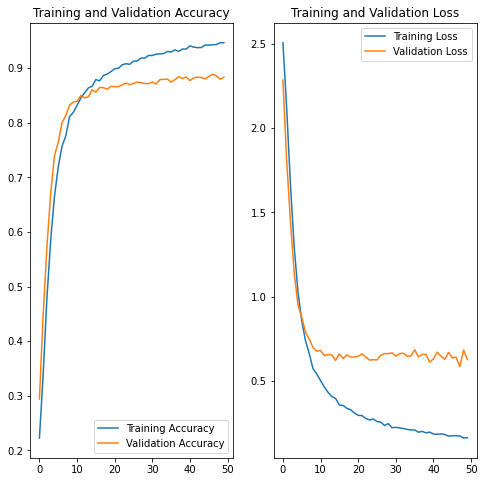

In [67]:
graphmodel(history4)

#### Model 4 Eval
Compared to the FSM, there was a modest increase in validation accuracy (less than .5%), but validation loss decreased by ~46%. 

## Model 5: Longer Leash
Tweaked dropout higher, more epochs

In [91]:
model5 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
%%time

epochs=100

history5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 9s 10ms/step - loss: 2.4941 - accuracy: 0.2280 - val_loss: 2.2451 - val_accuracy: 0.3117
Epoch 2/100
847/847 [==============================] - 8s 9ms/step - loss: 2.0969 - accuracy: 0.3461 - val_loss: 1.8018 - val_accuracy: 0.4570
Epoch 3/100
847/847 [==============================] - 8s 9ms/step - loss: 1.6698 - accuracy: 0.4735 - val_loss: 1.3799 - val_accuracy: 0.5941
Epoch 4/100
847/847 [==============================] - 8s 9ms/step - loss: 1.2935 - accuracy: 0.5903 - val_loss: 1.1436 - val_accuracy: 0.6677
Epoch 5/100
847/847 [==============================] - 8s 9ms/step - loss: 1.0170 - accuracy: 0.6734 - val_loss: 0.9042 - val_accuracy: 0.7504
Epoch 6/100
847/847 [==============================] - 8s 9ms/step - loss: 0.8470 - accuracy: 0.7246 - val_loss: 0.8194 - val_accuracy: 0.7796
Epoch 7/100
847/847 [==============================] - 8s 9ms/step - loss: 0.7299 - accuracy: 0.7629 - val_loss: 0.7554 - val_accuracy: 0.797

Epoch 58/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1435 - accuracy: 0.9531 - val_loss: 0.6490 - val_accuracy: 0.8925
Epoch 59/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1502 - accuracy: 0.9510 - val_loss: 0.6169 - val_accuracy: 0.8934
Epoch 60/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1441 - accuracy: 0.9521 - val_loss: 0.6468 - val_accuracy: 0.8912
Epoch 61/100
847/847 [==============================] - 8s 10ms/step - loss: 0.1369 - accuracy: 0.9567 - val_loss: 0.6610 - val_accuracy: 0.8909
Epoch 62/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1477 - accuracy: 0.9527 - val_loss: 0.6222 - val_accuracy: 0.8923
Epoch 63/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1405 - accuracy: 0.9543 - val_loss: 0.6196 - val_accuracy: 0.8964
Epoch 64/100
847/847 [==============================] - 8s 9ms/step - loss: 0.1438 - accuracy: 0.9544 - val_loss: 0.6249 - val_accuracy

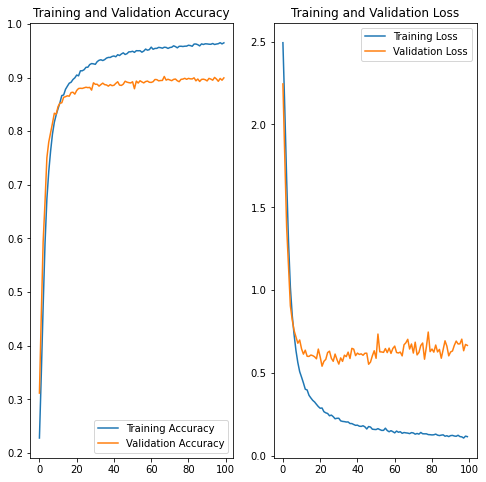

In [93]:
graphmodel(history5)

#### Model 5 Eval
Roughly a 1% increase in validation accuracy over model 4 with some increase in loss.  Clearly stalled in the 50-60 range.

## Model 6 Another Dropout Layer?

In [94]:
model6 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
%%time

epochs=100

history6 = model6.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 9s 10ms/step - loss: 2.6069 - accuracy: 0.1914 - val_loss: 2.4454 - val_accuracy: 0.2528
Epoch 2/100
847/847 [==============================] - 8s 10ms/step - loss: 2.3988 - accuracy: 0.2625 - val_loss: 2.2579 - val_accuracy: 0.3128
Epoch 3/100
847/847 [==============================] - 8s 10ms/step - loss: 2.1966 - accuracy: 0.3124 - val_loss: 2.0224 - val_accuracy: 0.3824
Epoch 4/100
847/847 [==============================] - 8s 10ms/step - loss: 1.9350 - accuracy: 0.3874 - val_loss: 1.7457 - val_accuracy: 0.4837
Epoch 5/100
847/847 [==============================] - 8s 10ms/step - loss: 1.7182 - accuracy: 0.4537 - val_loss: 1.5066 - val_accuracy: 0.5557
Epoch 6/100
847/847 [==============================] - 8s 10ms/step - loss: 1.5142 - accuracy: 0.5139 - val_loss: 1.3185 - val_accuracy: 0.6283
Epoch 7/100
847/847 [==============================] - 9s 10ms/step - loss: 1.3428 - accuracy: 0.5700 - val_loss: 1.1409 - val_accuracy:

847/847 [==============================] - 8s 10ms/step - loss: 0.3237 - accuracy: 0.8924 - val_loss: 0.5650 - val_accuracy: 0.8781
Epoch 58/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3199 - accuracy: 0.8917 - val_loss: 0.5316 - val_accuracy: 0.8841
Epoch 59/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3157 - accuracy: 0.8940 - val_loss: 0.5410 - val_accuracy: 0.8822
Epoch 60/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3293 - accuracy: 0.8909 - val_loss: 0.5411 - val_accuracy: 0.8799
Epoch 61/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3117 - accuracy: 0.8959 - val_loss: 0.5375 - val_accuracy: 0.8834
Epoch 62/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3263 - accuracy: 0.8909 - val_loss: 0.5250 - val_accuracy: 0.8858
Epoch 63/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3121 - accuracy: 0.8960 - val_loss: 0.5410 - val_accuracy: 0.879

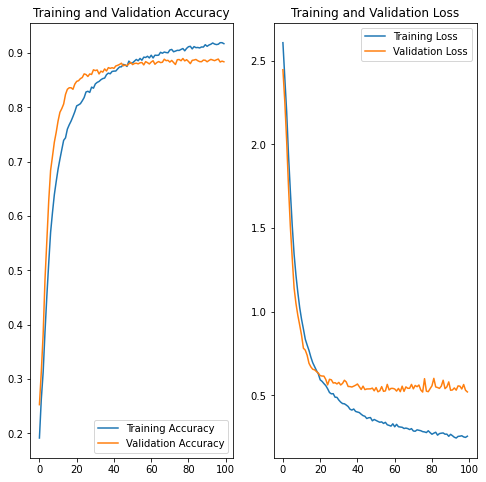

In [96]:
graphmodel(history6)

#### Model 6 Eval
Reduced overfitting on training... at the cost of slightly worse accuracy on validation. Val_loss was lower than model 5

## Model 7: Regularization
Added a dense layer and reduced dropout, to counterbalance regularization

In [112]:
model7 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer='l2'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.25),
  layers.Dense(num_classes)
])

model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [113]:
%%time

epochs=50

history7 = model7.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 9s 10ms/step - loss: 2.6789 - accuracy: 0.1889 - val_loss: 2.5463 - val_accuracy: 0.2251
Epoch 2/50
847/847 [==============================] - 8s 10ms/step - loss: 2.5532 - accuracy: 0.2257 - val_loss: 2.5324 - val_accuracy: 0.2469
Epoch 3/50
847/847 [==============================] - 8s 10ms/step - loss: 2.5221 - accuracy: 0.2546 - val_loss: 2.4732 - val_accuracy: 0.2803
Epoch 4/50
847/847 [==============================] - 8s 10ms/step - loss: 2.4713 - accuracy: 0.3024 - val_loss: 2.4137 - val_accuracy: 0.3379
Epoch 5/50
847/847 [==============================] - 8s 10ms/step - loss: 2.3755 - accuracy: 0.3790 - val_loss: 2.3152 - val_accuracy: 0.4121
Epoch 6/50
847/847 [==============================] - 8s 10ms/step - loss: 2.2485 - accuracy: 0.4624 - val_loss: 2.2708 - val_accuracy: 0.4658
Epoch 7/50
847/847 [==============================] - 8s 10ms/step - loss: 2.1222 - accuracy: 0.5359 - val_loss: 2.1358 - val_accuracy: 0.5420

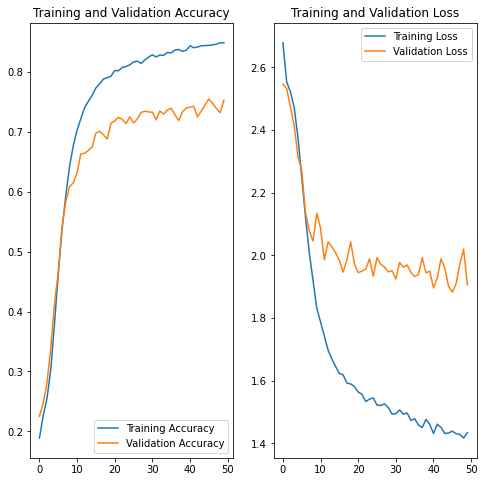

In [114]:
graphmodel(history7)

#### Model 7 Eval
Back to the drawing board.

## Model 8: Added convultional layer
Slightly tweaked more drop out layers from Model 5

In [122]:
model8 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
%%time

epochs=100

history8 = model8.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 11s 12ms/step - loss: 2.5637 - accuracy: 0.2077 - val_loss: 2.4783 - val_accuracy: 0.2359
Epoch 2/100
847/847 [==============================] - 9s 11ms/step - loss: 2.3912 - accuracy: 0.2541 - val_loss: 2.2205 - val_accuracy: 0.3048
Epoch 3/100
847/847 [==============================] - 10s 11ms/step - loss: 2.1662 - accuracy: 0.3191 - val_loss: 1.9888 - val_accuracy: 0.3751
Epoch 4/100
847/847 [==============================] - 10s 11ms/step - loss: 1.9641 - accuracy: 0.3774 - val_loss: 1.8232 - val_accuracy: 0.4496
Epoch 5/100
847/847 [==============================] - 9s 11ms/step - loss: 1.7853 - accuracy: 0.4280 - val_loss: 1.6456 - val_accuracy: 0.4970
Epoch 6/100
847/847 [==============================] - 9s 11ms/step - loss: 1.6394 - accuracy: 0.4762 - val_loss: 1.5180 - val_accuracy: 0.5367
Epoch 7/100
847/847 [==============================] - 10s 11ms/step - loss: 1.5214 - accuracy: 0.5127 - val_loss: 1.4362 - val_accur

847/847 [==============================] - 9s 11ms/step - loss: 0.4897 - accuracy: 0.8394 - val_loss: 0.6055 - val_accuracy: 0.8456
Epoch 58/100
847/847 [==============================] - 9s 10ms/step - loss: 0.4847 - accuracy: 0.8434 - val_loss: 0.5978 - val_accuracy: 0.8543
Epoch 59/100
847/847 [==============================] - 9s 11ms/step - loss: 0.4782 - accuracy: 0.8430 - val_loss: 0.6164 - val_accuracy: 0.8437
Epoch 60/100
847/847 [==============================] - 9s 11ms/step - loss: 0.4712 - accuracy: 0.8451 - val_loss: 0.6041 - val_accuracy: 0.8447
Epoch 61/100
847/847 [==============================] - 9s 11ms/step - loss: 0.4814 - accuracy: 0.8430 - val_loss: 0.6100 - val_accuracy: 0.8435
Epoch 62/100
847/847 [==============================] - 9s 11ms/step - loss: 0.4759 - accuracy: 0.8435 - val_loss: 0.6283 - val_accuracy: 0.8388
Epoch 63/100
847/847 [==============================] - 9s 11ms/step - loss: 0.4653 - accuracy: 0.8471 - val_loss: 0.6501 - val_accuracy: 0.836

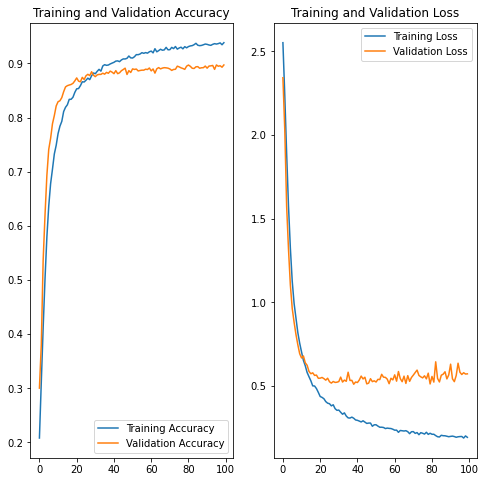

In [117]:
graphmodel(history8)

## Model 9
Changed kernal size for biggest conv layer

In [126]:
model9 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
%%time

epochs=100

history9 = model9.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 11s 12ms/step - loss: 2.5655 - accuracy: 0.2056 - val_loss: 2.4474 - val_accuracy: 0.2477
Epoch 2/100
847/847 [==============================] - 9s 11ms/step - loss: 2.3700 - accuracy: 0.2687 - val_loss: 2.2196 - val_accuracy: 0.3041
Epoch 3/100
847/847 [==============================] - 9s 11ms/step - loss: 2.1322 - accuracy: 0.3282 - val_loss: 1.9567 - val_accuracy: 0.4046
Epoch 4/100
847/847 [==============================] - 11s 12ms/step - loss: 1.8709 - accuracy: 0.4102 - val_loss: 1.7057 - val_accuracy: 0.4961
Epoch 5/100
847/847 [==============================] - 11s 13ms/step - loss: 1.6393 - accuracy: 0.4800 - val_loss: 1.4846 - val_accuracy: 0.5563
Epoch 6/100
847/847 [==============================] - 10s 12ms/step - loss: 1.4567 - accuracy: 0.5354 - val_loss: 1.3229 - val_accuracy: 0.6168
Epoch 7/100
847/847 [==============================] - 10s 12ms/step - loss: 1.3166 - accuracy: 0.5743 - val_loss: 1.2216 - val_accu

847/847 [==============================] - 9s 11ms/step - loss: 0.2780 - accuracy: 0.9096 - val_loss: 0.6127 - val_accuracy: 0.8571
Epoch 58/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2864 - accuracy: 0.9072 - val_loss: 0.5835 - val_accuracy: 0.8590
Epoch 59/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2823 - accuracy: 0.9075 - val_loss: 0.5878 - val_accuracy: 0.8562
Epoch 60/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2789 - accuracy: 0.9110 - val_loss: 0.5853 - val_accuracy: 0.8608
Epoch 61/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2865 - accuracy: 0.9099 - val_loss: 0.6212 - val_accuracy: 0.8523
Epoch 62/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2782 - accuracy: 0.9096 - val_loss: 0.6031 - val_accuracy: 0.8555
Epoch 63/100
847/847 [==============================] - 9s 11ms/step - loss: 0.2696 - accuracy: 0.9125 - val_loss: 0.5745 - val_accuracy: 0.863

## Model 10 Long Augument

In [129]:
model10 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
%%time

epochs=200

history10 = model10.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
847/847 [==============================] - 33s 37ms/step - loss: 2.5556 - accuracy: 0.2116 - val_loss: 2.4152 - val_accuracy: 0.2626
Epoch 2/200
847/847 [==============================] - 31s 37ms/step - loss: 2.4166 - accuracy: 0.2555 - val_loss: 2.3279 - val_accuracy: 0.2732
Epoch 3/200
847/847 [==============================] - 31s 37ms/step - loss: 2.3258 - accuracy: 0.2721 - val_loss: 2.1962 - val_accuracy: 0.3046
Epoch 4/200
847/847 [==============================] - 30s 36ms/step - loss: 2.2461 - accuracy: 0.2954 - val_loss: 2.1150 - val_accuracy: 0.3266
Epoch 5/200
847/847 [==============================] - 31s 36ms/step - loss: 2.1668 - accuracy: 0.3139 - val_loss: 2.0173 - val_accuracy: 0.3587
Epoch 6/200
847/847 [==============================] - 31s 37ms/step - loss: 2.1008 - accuracy: 0.3345 - val_loss: 1.9927 - val_accuracy: 0.3718
Epoch 7/200
847/847 [==============================] - 31s 36ms/step - loss: 2.0373 - accuracy: 0.3467 - val_loss: 1.9014 - val_ac

847/847 [==============================] - 31s 36ms/step - loss: 1.2259 - accuracy: 0.5976 - val_loss: 1.1659 - val_accuracy: 0.6573
Epoch 58/200
847/847 [==============================] - 30s 36ms/step - loss: 1.1984 - accuracy: 0.6129 - val_loss: 1.2194 - val_accuracy: 0.6261
Epoch 59/200
847/847 [==============================] - 31s 36ms/step - loss: 1.2170 - accuracy: 0.6041 - val_loss: 1.1744 - val_accuracy: 0.6556
Epoch 60/200
847/847 [==============================] - 30s 35ms/step - loss: 1.1927 - accuracy: 0.6113 - val_loss: 1.1470 - val_accuracy: 0.6590
Epoch 61/200
847/847 [==============================] - 30s 36ms/step - loss: 1.1964 - accuracy: 0.6098 - val_loss: 1.1289 - val_accuracy: 0.6691
Epoch 62/200
847/847 [==============================] - 31s 36ms/step - loss: 1.1861 - accuracy: 0.6137 - val_loss: 1.1550 - val_accuracy: 0.6536
Epoch 63/200
847/847 [==============================] - 30s 36ms/step - loss: 1.1844 - accuracy: 0.6117 - val_loss: 1.1946 - val_accuracy

847/847 [==============================] - 31s 36ms/step - loss: 1.0349 - accuracy: 0.6642 - val_loss: 1.0998 - val_accuracy: 0.6765
Epoch 114/200
847/847 [==============================] - 31s 37ms/step - loss: 1.0382 - accuracy: 0.6571 - val_loss: 1.0288 - val_accuracy: 0.6974
Epoch 115/200
847/847 [==============================] - 30s 36ms/step - loss: 1.0325 - accuracy: 0.6632 - val_loss: 1.0500 - val_accuracy: 0.6923
Epoch 116/200
847/847 [==============================] - 30s 36ms/step - loss: 1.0324 - accuracy: 0.6616 - val_loss: 1.0983 - val_accuracy: 0.6742
Epoch 117/200
847/847 [==============================] - 31s 36ms/step - loss: 1.0407 - accuracy: 0.6592 - val_loss: 1.0781 - val_accuracy: 0.6827
Epoch 118/200
847/847 [==============================] - 31s 37ms/step - loss: 1.0231 - accuracy: 0.6640 - val_loss: 1.1088 - val_accuracy: 0.6723
Epoch 119/200
847/847 [==============================] - 30s 36ms/step - loss: 1.0237 - accuracy: 0.6645 - val_loss: 1.0295 - val_ac

Epoch 169/200
847/847 [==============================] - 31s 37ms/step - loss: 0.9602 - accuracy: 0.6860 - val_loss: 0.9953 - val_accuracy: 0.7057
Epoch 170/200
847/847 [==============================] - 31s 36ms/step - loss: 0.9579 - accuracy: 0.6839 - val_loss: 1.1296 - val_accuracy: 0.6676
Epoch 171/200
847/847 [==============================] - 31s 37ms/step - loss: 0.9618 - accuracy: 0.6843 - val_loss: 1.0033 - val_accuracy: 0.7083
Epoch 172/200
847/847 [==============================] - 31s 36ms/step - loss: 0.9482 - accuracy: 0.6858 - val_loss: 0.9830 - val_accuracy: 0.7176
Epoch 173/200
847/847 [==============================] - 31s 36ms/step - loss: 0.9517 - accuracy: 0.6874 - val_loss: 1.0132 - val_accuracy: 0.7082
Epoch 174/200
847/847 [==============================] - 31s 36ms/step - loss: 0.9653 - accuracy: 0.6854 - val_loss: 1.0387 - val_accuracy: 0.6961
Epoch 175/200
847/847 [==============================] - 31s 36ms/step - loss: 0.9481 - accuracy: 0.6896 - val_loss: 1

## Model 11: Augment, no drop
Additional dense layer

In [131]:
model11 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),  
  layers.Dense(num_classes)
])

model11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [133]:
%%time

epochs=50

history11 = model11.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 32s 36ms/step - loss: 2.4671 - accuracy: 0.2371 - val_loss: 2.3222 - val_accuracy: 0.2679
Epoch 2/50
847/847 [==============================] - 31s 36ms/step - loss: 2.2446 - accuracy: 0.2919 - val_loss: 2.1760 - val_accuracy: 0.3073
Epoch 3/50
847/847 [==============================] - 30s 36ms/step - loss: 2.0569 - accuracy: 0.3456 - val_loss: 1.9751 - val_accuracy: 0.3765
Epoch 4/50
847/847 [==============================] - 30s 35ms/step - loss: 1.8569 - accuracy: 0.4045 - val_loss: 1.8626 - val_accuracy: 0.4164
Epoch 5/50
847/847 [==============================] - 30s 36ms/step - loss: 1.6906 - accuracy: 0.4578 - val_loss: 1.6937 - val_accuracy: 0.4630
Epoch 6/50
847/847 [==============================] - 31s 36ms/step - loss: 1.5431 - accuracy: 0.5060 - val_loss: 1.5295 - val_accuracy: 0.5187
Epoch 7/50
847/847 [==============================] - 30s 36ms/step - loss: 1.4099 - accuracy: 0.5477 - val_loss: 1.5544 - val_accuracy:

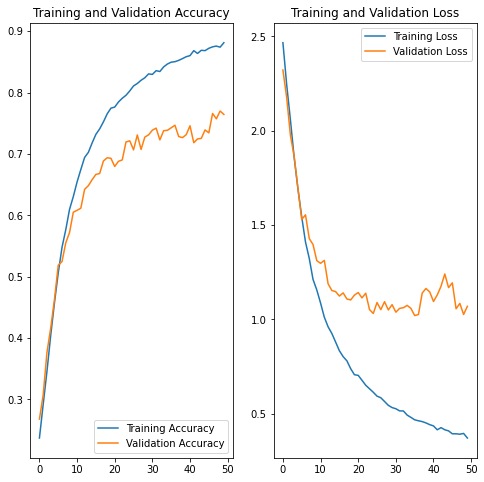

In [134]:
graphmodel(history11)

## Model 12: AVG Pooling?

In [136]:
model12 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),  
  layers.Dense(num_classes)
])

model12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [137]:
%%time

epochs=50

history12 = model12.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 31s 36ms/step - loss: 2.4978 - accuracy: 0.2268 - val_loss: 2.4008 - val_accuracy: 0.2524
Epoch 2/50
847/847 [==============================] - 30s 36ms/step - loss: 2.3236 - accuracy: 0.2734 - val_loss: 2.2293 - val_accuracy: 0.2970
Epoch 3/50
847/847 [==============================] - 31s 36ms/step - loss: 2.1565 - accuracy: 0.3186 - val_loss: 2.0520 - val_accuracy: 0.3476
Epoch 4/50
847/847 [==============================] - 30s 36ms/step - loss: 1.9958 - accuracy: 0.3656 - val_loss: 1.9272 - val_accuracy: 0.3889
Epoch 5/50
847/847 [==============================] - 30s 36ms/step - loss: 1.8428 - accuracy: 0.4116 - val_loss: 1.8178 - val_accuracy: 0.4277
Epoch 6/50
847/847 [==============================] - 30s 36ms/step - loss: 1.7080 - accuracy: 0.4508 - val_loss: 1.6733 - val_accuracy: 0.4679
Epoch 7/50
847/847 [==============================] - 31s 36ms/step - loss: 1.5853 - accuracy: 0.4911 - val_loss: 1.6210 - val_accuracy:

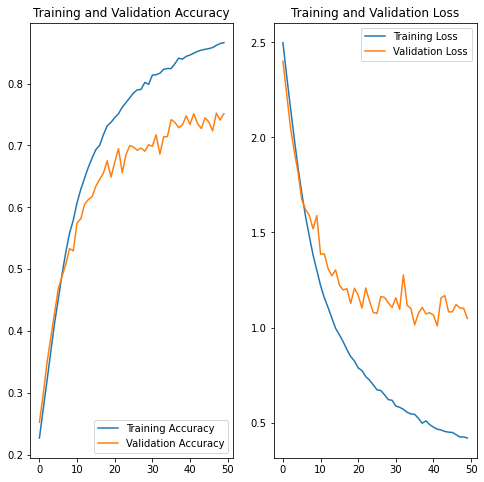

In [138]:
graphmodel(history12)

## Model 13 The Luckiest Model

In [140]:
model13 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dropout(0.13),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.13),
  layers.Dense(num_classes)
])

model13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [141]:
%%time

epochs=100

history13 = model13.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 35s 40ms/step - loss: 2.5583 - accuracy: 0.2026 - val_loss: 2.4747 - val_accuracy: 0.2297
Epoch 2/100
847/847 [==============================] - 33s 39ms/step - loss: 2.3855 - accuracy: 0.2594 - val_loss: 2.2676 - val_accuracy: 0.2939
Epoch 3/100
847/847 [==============================] - 33s 39ms/step - loss: 2.1991 - accuracy: 0.3122 - val_loss: 2.1171 - val_accuracy: 0.3321
Epoch 4/100
847/847 [==============================] - 33s 39ms/step - loss: 2.0495 - accuracy: 0.3497 - val_loss: 1.9547 - val_accuracy: 0.3755
Epoch 5/100
847/847 [==============================] - 33s 40ms/step - loss: 1.9174 - accuracy: 0.3893 - val_loss: 1.8499 - val_accuracy: 0.4124
Epoch 6/100
847/847 [==============================] - 34s 40ms/step - loss: 1.7812 - accuracy: 0.4323 - val_loss: 1.7408 - val_accuracy: 0.4571
Epoch 7/100
847/847 [==============================] - 33s 39ms/step - loss: 1.6837 - accuracy: 0.4598 - val_loss: 1.6598 - val_ac

847/847 [==============================] - 33s 39ms/step - loss: 0.6478 - accuracy: 0.7895 - val_loss: 1.0330 - val_accuracy: 0.7193
Epoch 58/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6236 - accuracy: 0.7971 - val_loss: 1.0189 - val_accuracy: 0.7355
Epoch 59/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6102 - accuracy: 0.8020 - val_loss: 1.0285 - val_accuracy: 0.7359
Epoch 60/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6091 - accuracy: 0.7994 - val_loss: 0.9802 - val_accuracy: 0.7387
Epoch 61/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6084 - accuracy: 0.8006 - val_loss: 1.0623 - val_accuracy: 0.7250
Epoch 62/100
847/847 [==============================] - 32s 38ms/step - loss: 0.6155 - accuracy: 0.8011 - val_loss: 1.0733 - val_accuracy: 0.7176
Epoch 63/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6019 - accuracy: 0.8047 - val_loss: 1.0162 - val_accuracy

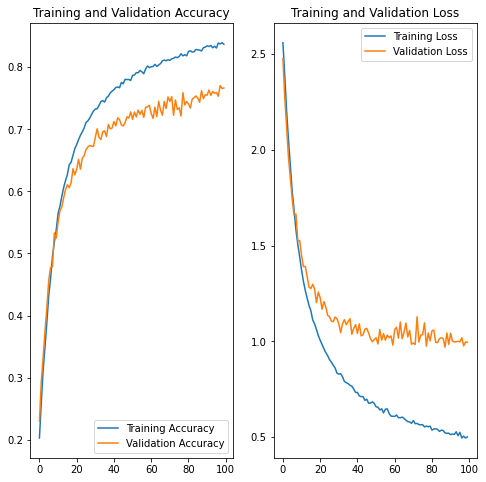

In [142]:
graphmodel(history13)

# Small Batch Tests 

In [143]:
train_ds8 = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=8)

val_ds8 = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=8)

AUTOTUNE = tf.data.AUTOTUNE

train_ds8 = train_ds8.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds8 = val_ds8.cache().prefetch(buffer_size=AUTOTUNE)

Found 33877 files belonging to 17 classes.
Using 27102 files for training.
Found 33877 files belonging to 17 classes.
Using 6775 files for validation.


## Model 14
Based on Model 5, but with smaller dropouts, because a smaller batch size should reduce overfitting.

In [149]:
model14 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

model14.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [150]:
%%time

epochs=100

history14 = model14.fit(
  train_ds8,
  validation_data=val_ds8,
  epochs=epochs
)

Epoch 1/100
3388/3388 [==============================] - 20s 6ms/step - loss: 2.4697 - accuracy: 0.2330 - val_loss: 2.2350 - val_accuracy: 0.3252
Epoch 2/100
3388/3388 [==============================] - 19s 6ms/step - loss: 1.9465 - accuracy: 0.4004 - val_loss: 1.6158 - val_accuracy: 0.5299
Epoch 3/100
3388/3388 [==============================] - 19s 6ms/step - loss: 1.3834 - accuracy: 0.5714 - val_loss: 1.1662 - val_accuracy: 0.6679
Epoch 4/100
3388/3388 [==============================] - 19s 6ms/step - loss: 1.0204 - accuracy: 0.6807 - val_loss: 0.9996 - val_accuracy: 0.7170
Epoch 5/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.7948 - accuracy: 0.7486 - val_loss: 0.8689 - val_accuracy: 0.7681
Epoch 6/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.6606 - accuracy: 0.7897 - val_loss: 0.8043 - val_accuracy: 0.7919
Epoch 7/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.5643 - accuracy: 0.8181 - val_loss: 0.7592 -

Epoch 57/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1820 - accuracy: 0.9485 - val_loss: 0.8980 - val_accuracy: 0.8698
Epoch 58/100
3388/3388 [==============================] - 19s 5ms/step - loss: 0.1722 - accuracy: 0.9503 - val_loss: 0.8888 - val_accuracy: 0.8688
Epoch 59/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1770 - accuracy: 0.9514 - val_loss: 0.8892 - val_accuracy: 0.8707
Epoch 60/100
3388/3388 [==============================] - 19s 5ms/step - loss: 0.1769 - accuracy: 0.9510 - val_loss: 0.9306 - val_accuracy: 0.8737
Epoch 61/100
3388/3388 [==============================] - 19s 5ms/step - loss: 0.1767 - accuracy: 0.9519 - val_loss: 0.8716 - val_accuracy: 0.8708
Epoch 62/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1700 - accuracy: 0.9529 - val_loss: 0.9268 - val_accuracy: 0.8759
Epoch 63/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1733 - accuracy: 0.9517 - val_loss: 0

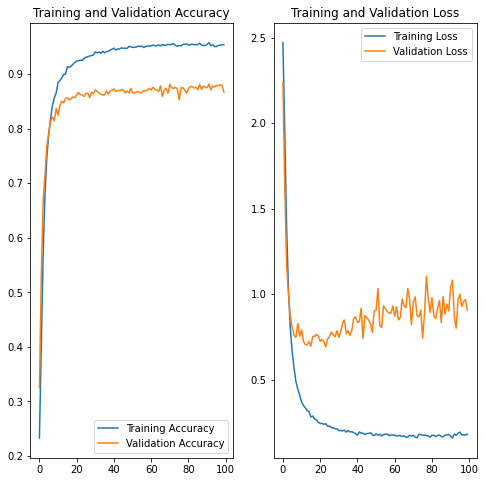

In [151]:
graphmodel(history14)

## Model 15

In [153]:
model15 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(num_classes)
])

model15.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
%%time

epochs=100

history15 = model15.fit(
  train_ds8,
  validation_data=val_ds8,
  epochs=epochs
)

Epoch 1/100
3388/3388 [==============================] - 54s 16ms/step - loss: 2.5436 - accuracy: 0.2131 - val_loss: 2.4568 - val_accuracy: 0.2527
Epoch 2/100
3388/3388 [==============================] - 53s 16ms/step - loss: 2.3898 - accuracy: 0.2651 - val_loss: 2.3387 - val_accuracy: 0.2649
Epoch 3/100
3388/3388 [==============================] - 53s 16ms/step - loss: 2.2304 - accuracy: 0.3042 - val_loss: 2.1864 - val_accuracy: 0.3209
Epoch 4/100
3388/3388 [==============================] - 53s 16ms/step - loss: 2.0905 - accuracy: 0.3418 - val_loss: 2.0199 - val_accuracy: 0.3681
Epoch 5/100
3388/3388 [==============================] - 52s 15ms/step - loss: 1.9791 - accuracy: 0.3781 - val_loss: 1.9379 - val_accuracy: 0.3866
Epoch 6/100
3388/3388 [==============================] - 52s 15ms/step - loss: 1.8824 - accuracy: 0.4070 - val_loss: 1.8427 - val_accuracy: 0.4103
Epoch 7/100
3388/3388 [==============================] - 53s 16ms/step - loss: 1.7923 - accuracy: 0.4324 - val_loss: 1

3388/3388 [==============================] - 53s 16ms/step - loss: 0.8623 - accuracy: 0.7314 - val_loss: 1.3577 - val_accuracy: 0.6528
Epoch 57/100
3388/3388 [==============================] - 52s 15ms/step - loss: 0.8627 - accuracy: 0.7336 - val_loss: 1.1810 - val_accuracy: 0.6821
Epoch 58/100
3388/3388 [==============================] - 52s 15ms/step - loss: 0.8549 - accuracy: 0.7380 - val_loss: 1.1920 - val_accuracy: 0.6778
Epoch 59/100
3388/3388 [==============================] - 52s 15ms/step - loss: 0.8413 - accuracy: 0.7415 - val_loss: 1.2091 - val_accuracy: 0.6813
Epoch 60/100
3388/3388 [==============================] - 53s 16ms/step - loss: 0.8517 - accuracy: 0.7389 - val_loss: 1.1803 - val_accuracy: 0.6896
Epoch 61/100
3388/3388 [==============================] - 53s 16ms/step - loss: 0.8358 - accuracy: 0.7432 - val_loss: 1.2180 - val_accuracy: 0.6831
Epoch 62/100
3388/3388 [==============================] - 52s 15ms/step - loss: 0.8337 - accuracy: 0.7457 - val_loss: 1.2289 

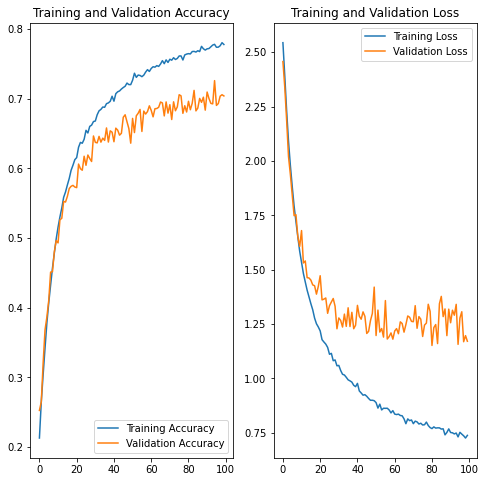

In [155]:
 graphmodel(history15)